# Decision trees and forests <a class="anchor" id="dtaforests"></a>

## Decision tree <a class="anchor" id="decisiontrees"></a>

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn import datasets, metrics
from snippets import plotDB
from sklearn.model_selection import train_test_split


In [4]:
from sklearn import tree

X,y=datasets.make_blobs(n_samples=200, centers=3, n_features=2, random_state=0, cluster_std=1.1)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25)

dt = tree.DecisionTreeClassifier(max_depth=2)
dt.fit(X_train, y_train)


print("Accurary in the training set..%f" % metrics.accuracy_score(y_true=y_train, y_pred=dt.predict(X_train)))
print("Accurary in the test set......%f" % metrics.accuracy_score(y_true=y_test, y_pred=dt.predict(X_test)))
print(dt)
tree.export_graphviz(dt, 'dt.dot', filled=True, rounded=True)

Accurary in the training set..0.953333
Accurary in the test set......0.880000
DecisionTreeClassifier(max_depth=2)


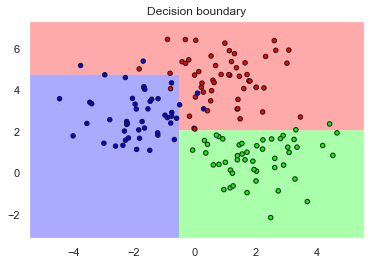

In [5]:
plotDB(dt, X_train, y_train)

### Optimize the tree depth

Best depth value is 2.000000
Accurary in the test set......0.920000


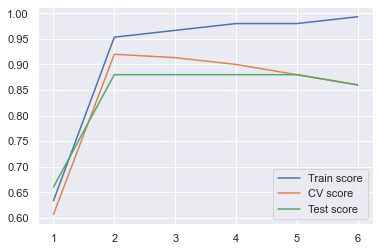

In [9]:
from sklearn.model_selection import cross_val_score


N=6
train_score=np.zeros(N)
test_score=np.zeros(N)
cv_score=np.zeros(N)
depth=np.arange(N)+1
for i in range(N):
    dt = tree.DecisionTreeClassifier(max_depth=depth[i])
    dt.fit(X_train, y_train)
    train_score[i]=metrics.accuracy_score(y_train, dt.predict(X_train))
    test_score[i]=metrics.accuracy_score(y_test, dt.predict(X_test))
    cv_score[i] = cross_val_score(dt, X_train, y_train, cv=5).mean()
plt.plot(depth, train_score, label="Train score")
plt.plot(depth, cv_score, label="CV score")
plt.plot(depth, test_score, label="Test score")
best_depth=depth[cv_score.argmax()]
print("Best depth value is %f" % best_depth)
plt.legend()
print("Accurary in the test set......%f" % cv_score.max())

- It seems that two is the optimal depth of the decision tree, since after that the accuracy of the cross validation is not increased any more. 
- The accuracy in the training set increases up to 100%, untill every point is in its own leaf, but that is only overfitting to the training data
- Test score shows the same message than cross validation
- Therefore do not use test data in optimising the model. Use it only in the end, when you have selected the optimal model using cross validation

Red more from [Skikit Learn](https://scikit-learn.org/stable/modules/tree.html)


# Ensemble methods <a class="anchor" id="ensemblemethods"></a>

- Bagging in [Skikit Learn](https://scikit-learn.org/stable/modules/ensemble.html)
  - A subset of the training data is selected and a full decision trees or other classifier is trained for it
  - The output of all predictors in the bag are then aggregated by voting, averaging or other methods
  - This method reduces the variance in the predictor generation process by introducing some randomness
- Boosting is another method to combine multiple predictors

## Bagging <a class="anchor" id="Bagging"></a>

### Randomized trees   <a class="anchor" id="RandomizedTrees"></a>
- Forest of randomized trees is one famous bagging method. it works as follows
  1. A random partition of data is drawn from the training data to bootstrap the tree structure
  1. The tree may use all features or only a random subset of available features
  1. The output is again aggregated from all predictors
  1. The two sources of randomness stabilizes the tree structure and reduces overfitting
- Read more from [Skikit Learn](https://scikit-learn.org/stable/modules/ensemble.html#forests-of-randomized-trees)

### Extratrees classifier (Extremely randomized trees)
- Even more random 
- The threshold rules are selected at random for randomly selected features
- The best thresholding rules are voted
- Read more from [Skikit Learn](https://scikit-learn.org/stable/modules/ensemble.html#extremely-randomized-trees)

### Optimising the parameters fo the Extratrees classifier

- Extratrees classifier has already many more parameters than normal decision tree.
- It is not convenient to try them all to find out an optimal combination
- Hand made optimisation loop with cross validation can be used as shown previously to make exhaustive search
- There is also better method in Scikit Learn, called as `GridSearchCV`
- It uses an optimisation algorithm and CV to find out optimal parameters
- First we just need to define which variables are going to be searched and in which range
- Then we let the optimisation algorith to tune the predictor and we just used the optimal version
- Note that we already got higher accuracy than with using a single tree predictor

In [10]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV

X,y=datasets.make_blobs(n_samples=200, centers=3, n_features=2, random_state=0, cluster_std=1.1)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25)

et = ExtraTreesClassifier(max_depth=5, min_samples_split=2, n_estimators=9)
et.fit(X_train, y_train)

# Set the parameters by cross-validation
tuned_parameters = [{'max_depth': range(3,10), 'min_samples_split': range(2,5),
                     'n_estimators': range(5,30)}]

#  Use the GridSearch to find out the best paramers using 5 fold cross validation
tune_et=GridSearchCV(et, tuned_parameters, cv=3);
tune_et.fit(X_train, y_train);
optimal_et=tune_et.best_estimator_

print("Accurary in the training set..%f" % metrics.accuracy_score(y_true=y_train, y_pred=optimal_et.predict(X_train)))
print("Accurary in the test set......%f" % metrics.accuracy_score(y_true=y_test, y_pred=optimal_et.predict(X_test)))
print(optimal_et)

Accurary in the training set..0.940000
Accurary in the test set......0.920000
ExtraTreesClassifier(max_depth=4, min_samples_split=4, n_estimators=16)


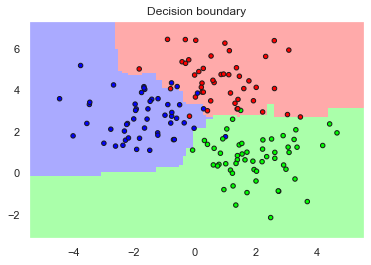

In [11]:
plotDB(optimal_et, X_train, y_train)

# Boosting <a class="anchor" id="Boosting"></a>
  - Construct weak random trees and chain them after each other on modified version of the data
  - Examples [Adaboost](https://scikit-learn.org/stable/modules/ensemble.html#adaboost)
    [Gradient Tree Boosting](https://scikit-learn.org/stable/modules/ensemble.html#gradient-tree-boosting)
    [XGBoost](https://xgboost.readthedocs.io/en/latest/)

## Adaboost <a class="anchor" id="AdaBoost"></a>
1. First create one weak predictor, which is perhaps only slightly better than guessing
1. Assign equal weight $w_i=1/N$ to each of the N samples
1. Repeat following boosting iteration M times:
  1. Try to predict the data with one weak predictor
  1. Find out which samples were incorrectly classified, and increase their weights, decrease the weights of correctly classified samples
  1. Train the next predictor with the weighted data so that it concentrates especially to those samples which were difficult for the classifiers this far. 
1. The final classification result is voted by the predictors

| First publications|
| -------------------|
| Freund, Y., & Schapire, R. E. (1997). A Decision-Theoretic Generalization of On-Line Learning and an Application to Boosting. Journal of Computer and System Sciences, 55(1), 119–139. https://doi.org/10.1006/jcss.1997.1504 |
| Drucker, H. (1997). Improving Regressors using Boosting Techniques. ICML. |
|  Hastie, T., Rosset, S., Zhu, J., & Zou, H. (2009). Multi-class AdaBoost. Statistics and Its Interface, 2(3), 349–360. https://doi.org/10.4310/SII.2009.v2.n3.a8
|


## Gradient Tree Boosting <a class="anchor" id="GBRT"></a>
 - Also called as Gradient Boosted Regression Trees (GBRT)
 - Improved version of Adaboost
 - The predictor is an aggregation of many weak individual predictors, often small decision trees, like in Adaboost
 - The main difference is that the boosting in GBRT:s is implemented as an optimisation algorithm
 
 $$Obj(\Theta) = \underbrace{L(\Theta)}_{Training Loss} + \underbrace{\Omega(\Theta)}_{Regularization}$$
 
 

  $$Obj(\Theta) = \underbrace{L(\Theta)}_{Training Loss} + \underbrace{\Omega(\Theta)}_{Regularization}$$

 - The target of the optimisation is to minimize the Objective function
 - The model fitness involves minimization of th training loss and model complexity (Regularization term)
 - Training loss function is often a squared distance $L(\hat{y}_i,y_i) = (\hat{y}_i -y_i)^2$
 - Regularization term is usually either 
   - $L_2$ norm: $\Omega(w)=\lambda \Vert w \Vert ^2$ or 
   - $L_1$ norm: $\Omega(w)=\lambda \vert w \vert$
   
 - Optimizing training loss improves the prediction capability of the model, because it is hoped that the predictor will learn the underlying distributions
 - Optimizing regularization encourages simples modes. They tend to predict better for future data, since simpler methods do not suffer from overfitting as easily as complex models
 - Read more from Interesting [slides about gradient boosting](https://homes.cs.washington.edu/~tqchen/pdf/BoostedTree.pdf)
 
| First publications|
| -------------------|
| Breiman, L. (1997). Arcing the edge. Technical Report 486, Statistics Department, University of California at ….
 |

## Extreme Gradient Boosting (XGBoost) <a class="anchor" id="XGBoost"></a>
- A library implementing Gradient Tree Boosting
- Available for many programming languages
- Read more from [XGBoost Tutorials](https://xgboost.readthedocs.io/en/latest/tutorials/index.html)

| First publications|
| -------------------|
| Friedman, J. H., Hastie, T., & Tibshirani, R. (2000). Additive logistic regression: A statistical view of boosting. https://doi.org/10.1214/aos/1016218223 |
| Friedman, J. H. (2001). Greedy function approximation: A gradient boosting machine. The Annals of Statistics, 29(5), 1189–1232. https://doi.org/10.1214/aos/1013203451|
| Friedman, J. H. (2002). Stochastic gradient boosting. Computational Statistics & Data Analysis, 38(4), 367–378.  https://doi.org/10.1016/S0167-9473(01)00065-2|
| Chen, T., & Guestrin, C. (2016). XGBoost: A Scalable Tree Boosting System. Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining - KDD ’16, 785–794. https://doi.org/10.1145/2939672.2939785|




In [12]:
from sklearn.ensemble import GradientBoostingClassifier
bt = GradientBoostingClassifier(n_estimators=9, learning_rate=1, max_depth=1, random_state=0)
bt.fit(X_train, y_train)

print("Accurary in the training set..%f" % metrics.accuracy_score(y_true=y_train, y_pred=bt.predict(X_train)))
print("Accurary in the test set......%f" % metrics.accuracy_score(y_true=y_test, y_pred=bt.predict(X_test)))
print(bt)

Accurary in the training set..0.966667
Accurary in the test set......0.900000
GradientBoostingClassifier(learning_rate=1, max_depth=1, n_estimators=9,
                           random_state=0)


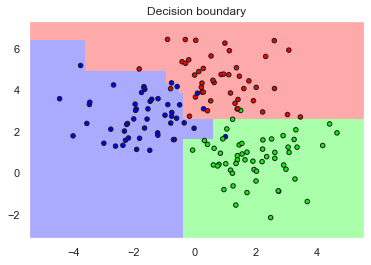

In [13]:
plotDB(bt, X_train, y_train)